## Data Loading & Preprocessing

In [ ]:
!pip install ucimlrepo

In [ ]:
import torch, pandas as pd, numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from ucimlrepo import fetch_ucirepo

In [ ]:
# fetch dataset
concrete_compressive_strength = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets

# rename as paper code
y = y.rename(columns={
    "Concrete compressive strength": "Strength (Mean)"
})

# rename X columns as paper code
X_rename = {
    "Blast Furnace Slag": "Slag",
    "Superplasticizer": "HRWR",
    "Age": "Time"
}

X = X.rename(columns=X_rename)

# put the 8 inputs in the order expected by the paper code
x_cols = [
    "Cement",
    "Slag",
    "Fly Ash",
    "Water",
    "HRWR",
    "Coarse Aggregate",
    "Fine Aggregate",
    "Time"
]

# add additional cost target
COST_COEFF = np.array([0.12,0.05,0.03,0.001,1.50,0.008,0.006])
GWP = np.dot((X[x_cols].values)[:, :-1], COST_COEFF)
y["GWP"] = GWP

y_cols = [
    "GWP",
    "Strength (Mean)"
]


X = torch.tensor(X[x_cols].values, dtype=torch.float32)
Y = torch.tensor(y[y_cols].values, dtype=torch.float32)

# cleaned data
X.shape, Y.shape

(torch.Size([1030, 8]), torch.Size([1030, 2]))

## Train GP Strength Model

In [ ]:
!pip install botorch gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.3/738.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade botorch gpytorch

In [ ]:
from models import fit_strength_gp

In [ ]:
Y_strength = Y[:, 1:]

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_strength, test_size=0.1, random_state=42)

# build a near-noiseless variance tensor
Yvar = torch.full_like(Y_train, 1e-4)

# gp bounds
bounds = torch.stack([X_train.amin(0), X_train.amax(0)])


In [ ]:
# train the strength gp surrogate
gp_strength = fit_strength_gp(
    X=X_train,
    Y=Y_train,
    Yvar=Yvar,
    X_bounds=bounds,
    use_fixed_noise=True
)

/content/models.py:342: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(**model_kwargs)
/usr/local/lib/python3.11/dist-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Text(0, 0.5, 'Predicted MPa')

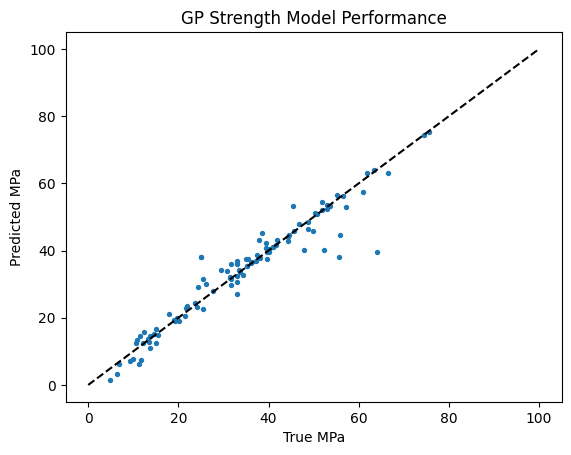

In [ ]:
# quick test
with torch.no_grad():
    pred = gp_strength.posterior(X_test).mean.squeeze(-1)

plt.title('GP Strength Model Performance')
plt.scatter(Y_test.numpy(), pred.numpy(), s=8)
plt.plot([0,100],[0,100],'k--'); plt.xlabel('True MPa'); plt.ylabel('Predicted MPa')


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

<ipython-input-19-35f7e1495a68>:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = y_all - y_pred


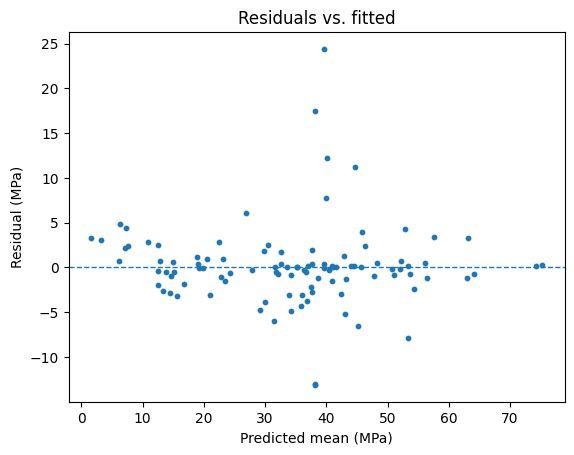

Fit statistics
RMSE: 21.038 MPa
MAE:  2.605 MPa
R²:  0.921


In [ ]:
# print metrics
gp = gp_strength
x_all, y_all = X_test, Y_test.squeeze(-1)

with torch.no_grad():
    post = gp.posterior(x_all)
    y_pred  = post.mean.squeeze(-1).cpu().numpy()
    y_var   = post.variance.squeeze(-1).clamp_min(1e-10).cpu().numpy()
    y_std   = np.sqrt(y_var)

# residuals vs. fitted
res = y_all - y_pred
plt.scatter(y_pred, res, s=10)
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel('Predicted mean (MPa)')
plt.ylabel('Residual (MPa)')
plt.title('Residuals vs. fitted')
plt.show()

# summary metrics
rmse  = mean_squared_error(y_all, y_pred)
mae   = mean_absolute_error(y_all, y_pred)
r2    = r2_score(y_all, y_pred)

print("Fit statistics")
print(f"RMSE: {rmse:6.3f} MPa")
print(f"MAE: {mae:6.3f} MPa")
print(f"R²: {r2:6.3f}")

In [ ]:
# save the model for later use
torch.save(
    {
        "state_dict": gp_strength.state_dict(),
        "x_mean": X.mean(0),
        "x_std":  X.std(0),
    },
    "strength_gp_state.pt",
)

## Define cost objective

In [ ]:
from models import fit_gwp_gp

In [ ]:
# evaluate negative cost (so we’re maximising −cost)
Y_cost = -Y[:, 0:1]

# build a near-noiseless variance tensor
Yvar_cost = torch.full_like(Y_cost, 1e-6)

# bounds for the 7 composition variables
X_bounds_comp = torch.stack((X.min(dim=0)[0], X.max(dim=0)[0]))

cost_gp = fit_gwp_gp(
    X=X, Y=Y_cost, Yvar=Yvar_cost, X_bounds=X_bounds_comp, use_fixed_noise=True
)

/content/models.py:257: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(**model_kwargs)
/usr/local/lib/python3.11/dist-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


## Predicted Pareto frontier

In [ ]:
from botorch.models import ModelListGP
from utils import predict_pareto, get_mortar_constraints, get_bounds, sample_q_batches_from_polytope
from botorch.utils.multi_objective.pareto import is_non_dominated

In [ ]:
# build the joint model list
model_list = ModelListGP(cost_gp, gp_strength)

In [ ]:
# use a Polytope sampler to generate a random set of points satisfying the (adjusted) constraints
# compute the Pareto frontier based on the predictive mean of the model.
bounds = get_bounds(x_cols)
eq_cons, ineq_cons = get_mortar_constraints(x_cols, verbose=False)

N_CAND = 10000
X_cand = sample_q_batches_from_polytope(
    n=N_CAND, q=1, bounds=bounds,
    equality_constraints=eq_cons,
    inequality_constraints=ineq_cons,
    seed=0,
    n_burnin=1000,
    n_thinning=10
).squeeze(-2)

In [ ]:
with torch.no_grad():
    post = model_list.posterior(X_cand)
    Y_cand = post.mean
    Y_target = Y_cand[..., torch.tensor([0,1], device=Y_cand.device)]
    pareto = is_non_dominated(Y_target)

X_pareto, Y_pareto = X_cand[pareto], Y_target[pareto]

# sort by descending –Cost (= ascending true Cost)
idx = Y_pareto[:,0].argsort(descending=True)
X_pareto, Y_pareto = X_pareto[idx], Y_pareto[idx]

print(f"Found {X_pareto.shape[0]} Pareto‑optimal mixtures (out of {N_CAND}).")
print("Top 10 by lowest predicted Cost:")
for i,(x,y) in enumerate(zip(X_pareto[:10], Y_pareto[:10])):
    true_cost = -y[0].item() # flip sign back
    strength28 = y[1].item()
    print(f"{i:02d}: Cost = ${true_cost:8.1f}  |  Strength = {strength28:7.1f} psi  |  mix = {x.cpu().numpy()}")

Found 13 Pareto‑optimal mixtures (out of 10000).
Top 10 by lowest predicted Cost:
00: Cost = $    65.0  |  Strength =    33.6 psi  |  mix = [3.1351089e+02 1.2366392e+02 1.0164252e+02 2.1544868e+02 1.7784343e+00
 9.0683759e+02 1.3361826e+03 1.2729781e+00]
01: Cost = $    65.1  |  Strength =   105.6 psi  |  mix = [ 323.30353     44.550793    54.01775    154.08139      2.5854304
 1209.667     1453.1279      18.20502  ]
02: Cost = $    69.6  |  Strength =   111.8 psi  |  mix = [ 306.3383    111.61931    89.48482   230.14668     4.576622 1157.7756
 1367.5576     23.043911]
03: Cost = $    70.0  |  Strength =   113.5 psi  |  mix = [ 382.97873     17.060982    86.624306   226.1946       3.4271927
  862.65424   1388.3359      24.640781 ]
04: Cost = $    74.8  |  Strength =   115.0 psi  |  mix = [ 369.37823    153.96706     32.30043    240.60931      2.7229161
 1193.85      1319.3542      26.19323  ]
05: Cost = $    76.6  |  Strength =   116.1 psi  |  mix = [ 361.86658    46.86798   168.48563  

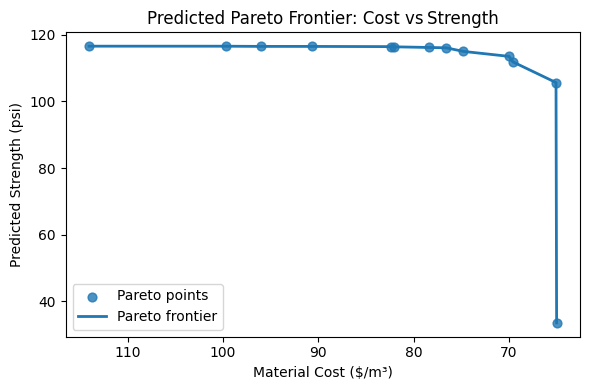

In [ ]:
# convert tensors to numpy and flip sign so cost is POSITIVE dollars
cost = (-Y_pareto[:, 0]).cpu().numpy() # $/m³ (lower = better)
strength = Y_pareto[:, 1].cpu().numpy() # 28‑day strength (psi)

# sort by cost for a clean line plot
order = np.argsort(cost)
cost_s = cost[order]
strength_s = strength[order]

plt.figure(figsize=(6, 4))
plt.scatter(cost, strength, s=40, alpha=0.8, label="Pareto points")
plt.plot(cost_s, strength_s, lw=2, label="Pareto frontier")

plt.gca().invert_xaxis() # put “better” (lower) cost on the right
plt.xlabel("Material Cost ($/m³)")
plt.ylabel("Predicted Strength (psi)")
plt.title("Predicted Pareto Frontier: Cost vs Strength")
plt.legend()
plt.tight_layout()
plt.show()

## Custom MOBO Training

In [ ]:
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [ ]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [ ]:
from torch.quasirandom import SobolEngine
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import SumMarginalLogLikelihood
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.multi_objective.hypervolume import Hypervolume

In [ ]:
cost_c = torch.tensor([0.12, 0.05, 0.03, 0.001, 1.50, 0.008, 0.006, 0.0],
                      dtype=X.dtype, device=X.device)
def cost_fn(x):
    return (x * cost_c).sum(dim=-1, keepdim=True)

In [ ]:
# 20‐point Sobol LHS in your normalized bounds
n_init = 20
train_X = draw_sobol_samples(bounds=bounds, n=1, q=n_init).squeeze(0)

# “ground truth” = your pre‐trained Ament‑et‑al. strength GP + analytic cost
with torch.no_grad():
    y_strength = gp_strength.posterior(train_x).mean
y_cost = cost_fn(train_x)
# flip cost so both objectives are maximized
train_Y = torch.cat([y_strength, -y_cost], dim=-1)

In [ ]:
def fit_mobo_model(X, Y):
    # X: (N,8) normalized, Y: (N,2)
    gp1 = SingleTaskGP(X, Y[..., 0:1], outcome_transform=Standardize(m=1))
    gp2 = SingleTaskGP(X, Y[..., 1:2], outcome_transform=Standardize(m=1))
    model = ModelListGP(gp1, gp2).to(**tkwargs)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

In [ ]:
bounds_unnorm = torch.stack([
    train_X.min(dim=0).values,
    train_X.max(dim=0).values
], dim=0).to(**tkwargs)

In [ ]:
def evaluate_objectives(x_unnorm):
    # x_unnorm: (q×8) in original units
    # f1: surrogate strength
    f1 = gp_strength.posterior(x_unnorm.type(torch.float32)).mean
    # f2: negative cost (so we maximize both)
    cost = cost_fn(x_unnorm)
    f2 = -cost
    return torch.cat([f1, f2], dim=-1)

In [ ]:
# set
batch_size = 4
n_iter = 25
hvs_morbo = []
dim = train_X.shape[-1]
obj_history = [train_Y]

for itr in range(n_iter):
    # a) Fit/update GP
    model = fit_mobo_model(train_X, train_Y)
    # b) Build acquisition (qNEHVI)
    with torch.no_grad():
        pred_means = model.posterior(train_X).mean
    partitioning = FastNondominatedPartitioning(ref_point=ref_point, Y=pred_means)
    acqf = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),
        X_baseline=train_X,
        prune_baseline=True,
        sampler=sampler,
    )
    # c) Optimize acquisition in [0,1]^d
    new_x, _ = optimize_acqf(
        acq_function=acqf,
        bounds=torch.stack([torch.zeros(dim,**tkwargs), torch.ones(dim,**tkwargs)]),
        q=batch_size,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit":5,"maxiter":200},
        sequential=True,
    )
    # d) Evaluate and append
    new_x_unnorm = unnormalize(new_x, bounds_unnorm)
    new_obj = evaluate_objectives(new_x_unnorm)
    obj_history.append(new_obj)
    train_x = torch.cat([train_x, new_x], dim=0)
    train_x_norm = train_x
    train_y = torch.cat([train_y, new_obj], dim=0)
    # e) Rebuild model for next iteration
    models = []
    for i in range(train_y.shape[-1]):
        yi = train_y[..., i:i+1]
        models.append(
            SingleTaskGP(train_x_norm, yi, outcome_transform=Standardize(m=1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # f) Record hypervolume
    mask = is_non_dominated(train_y)
    hv = Hypervolume(ref_point).compute(train_y[mask])
    hvs_morbo.append(hv)

<ipython-input-70-36083653d810>:3: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp1 = SingleTaskGP(X, Y[..., 0:1], outcome_transform=Standardize(m=1))
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
<ipython-input-70-36083653d810>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp2 = SingleTaskGP(X, Y[..., 1:2], outcome_transform=Standardize(m=1))
/usr/local/lib/python3.11/dist

## Random search baseline (sobol)



In [ ]:
# random‑search baseline
hvs_random = []
rand_x = train_X.clone()
rand_y = train_Y.clone()
rand_obj_history = [train_Y.clone()]
for itr in range(n_iter):
    rx = draw_sobol_samples(
        bounds=torch.stack([torch.zeros(dim,**tkwargs), torch.ones(dim,**tkwargs)]),
        n=1, q=batch_size
    ).squeeze(0)
    ru = unnormalize(rx, bounds_unnorm)
    ro = evaluate_objectives(ru)
    rand_obj_history.append(ro)
    rand_x = torch.cat([rand_x, rx], dim=0)
    rand_y = torch.cat([rand_y, ro], dim=0)
    mask = is_non_dominated(rand_y)
    hv = Hypervolume(ref_point).compute(rand_y[mask])
    hvs_random.append(hv)

## Evaluation

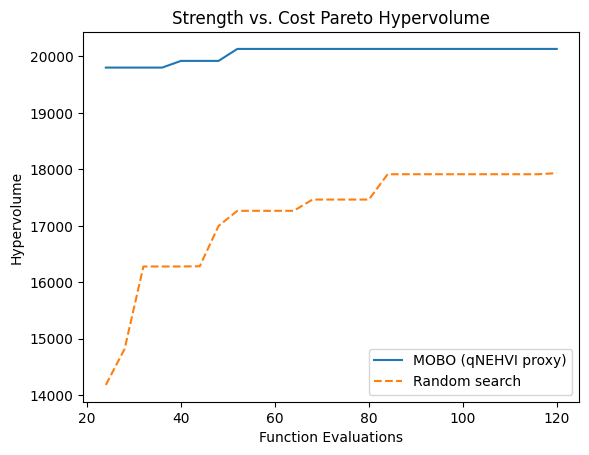

In [ ]:
total_evals = n_init + torch.arange(1, n_iter+1)*batch_size
plt.plot(total_evals, torch.tensor(hvs_morbo), label="MOBO (qNEHVI proxy)")
plt.plot(total_evals, torch.tensor(hvs_random), label="Random search", linestyle="--")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.title("Strength vs. Cost Pareto Hypervolume")
plt.show()

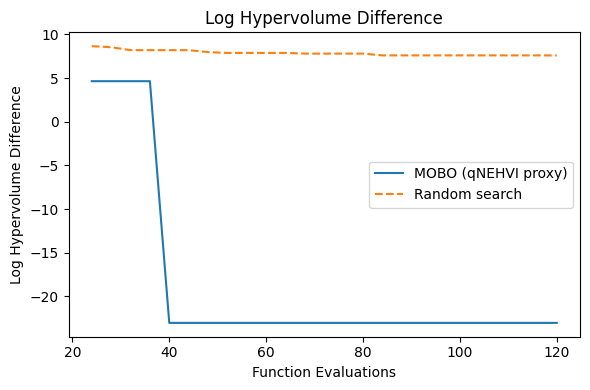

In [ ]:
with torch.no_grad():
    # Evaluate both objectives on all dataset points
    gt_obj = evaluate_objectives(train_X)

# Mask out only the non‑dominated “true” Pareto points
mask_gt = is_non_dominated(gt_obj)
hv_true = Hypervolume(ref_point).compute(gt_obj[mask_gt])

# Convert recorded hypervolumes (from your loops) to NumPy arrays
hvs_morbo_np = np.array(hvs_morbo)    # shape (n_iter,)
hvs_rand_np  = np.array(hvs_random)   # shape (n_iter,)

# Safety: clamp small positive values inside log
eps = 1e-10
diff_morbo = np.log(np.clip(hv_true - hvs_morbo_np, a_min=eps, a_max=None))
diff_rand  = np.log(np.clip(hv_true - hvs_rand_np,  a_min=eps, a_max=None))

plt.figure(figsize=(6,4))
plt.plot(total_evals, diff_morbo, label="MOBO (qNEHVI proxy)")
plt.plot(total_evals, diff_rand,  label="Random search", linestyle="--")
plt.xlabel("Function Evaluations")
plt.ylabel("Log Hypervolume Difference")
plt.title("Log Hypervolume Difference")
plt.legend()
plt.tight_layout()
plt.show()

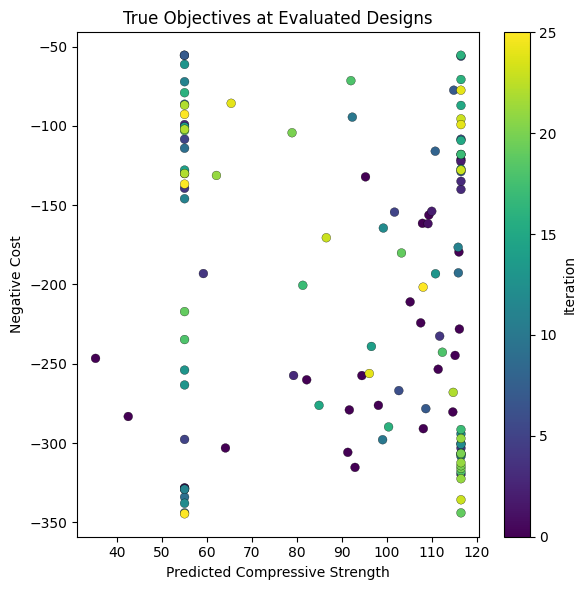

In [ ]:
all_objs = torch.cat(obj_history, dim=0)  # shape: (total_evals, 2)

# Build a 1D tensor of iteration numbers for each point
iters = []
for it, objs in enumerate(obj_history):
    iters.extend([it] * objs.shape[0])
iters = torch.tensor(iters, dtype=torch.float32)

plt.figure(figsize=(6,6))
sc = plt.scatter(
    all_objs[:, 0].detach().cpu().numpy(),
    all_objs[:, 1].detach().cpu().numpy(),
    c=iters,                     # color by iteration
    cmap="viridis",
    s=40,
    edgecolor="k",
    linewidth=0.2,
)
plt.colorbar(sc, label="Iteration")
plt.xlabel("Predicted Compressive Strength")
plt.ylabel("Negative Cost")
plt.title("True Objectives at Evaluated Designs")
plt.tight_layout()
plt.show()

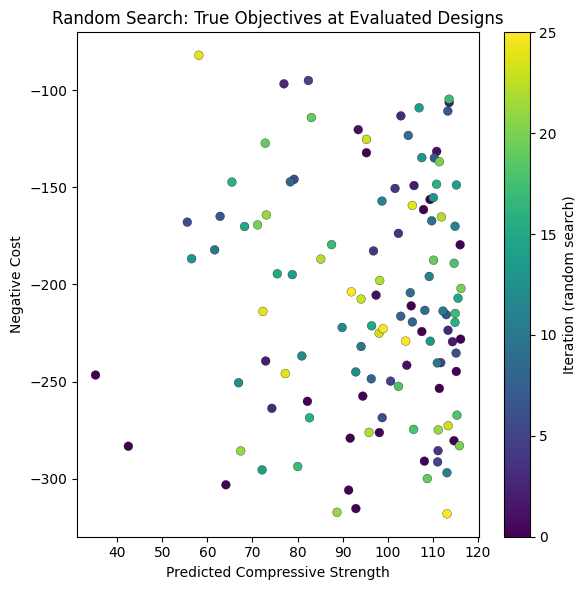

In [ ]:
all_rand_objs = torch.cat(rand_obj_history, dim=0)

rand_iters = []
for it, objs in enumerate(rand_obj_history):
    rand_iters.extend([it] * objs.shape[0])
rand_iters = torch.tensor(rand_iters, dtype=torch.float32)

plt.figure(figsize=(6,6))
sc = plt.scatter(
    all_rand_objs[:, 0].detach().cpu().numpy(),
    all_rand_objs[:, 1].detach().cpu().numpy(),
    c=rand_iters,
    cmap="viridis",
    s=40,
    edgecolor="k",
    linewidth=0.2,
)
plt.colorbar(sc, label="Iteration (random search)")
plt.xlabel("Predicted Compressive Strength")
plt.ylabel("Negative Cost")
plt.title("Random Search: True Objectives at Evaluated Designs")
plt.tight_layout()
plt.show()